# Dataset data analysis

In [3]:
import math
import re
import numpy as np
from clyent import color
from numpy import mean
from numpy import std
import pandas as pandas
import matplotlib.pyplot as plt
import seaborn as seaborn


import nltk

from numba import jit
import json
import string
punctuations_list = string.punctuation


### Data loading

#### Read both data files.
Note: The file wiki-auto-part-2-data.json has no sentence_alignments, while the wiki-auto-part-1-data.json has sentence_alignment and paragraph_alignment

In [4]:
%%time
dataset_cols_df_wiki_part_1 = ['simple', 'normal', 'sentence_alignment','paragraph_alignment']
df_wiki_part_1 = pandas.read_json(
    'wiki-auto-part-1-data.json',
    encoding='utf8',
    orient='index'
)
# Convert the list of lists sentence_alignment and paragraph_alignment into a list of tuples
df_wiki_part_1.sentence_alignment = df_wiki_part_1.sentence_alignment.apply(lambda alignment_list: [tuple(alignment) for alignment in alignment_list])
df_wiki_part_1.paragraph_alignment = df_wiki_part_1.paragraph_alignment.apply(lambda alignment_list: [tuple(alignment) for alignment in alignment_list])
df_wiki_part_1.head(10)

CPU times: user 9.33 s, sys: 2.76 s, total: 12.1 s
Wall time: 13.4 s


,simple,normal,sentence_alignment,paragraph_alignment
0,"{'id': 702227, 'title': 'Lata Mondal', 'url': ...","{'id': 41918715, 'title': 'Lata Mondal', 'url'...","[(simple-702227-0-0, normal-41918715-0-0), (si...","[(simple-702227-0, normal-41918715-0)]"
1,"{'id': 697879, 'title': 'Tuulikki Ukkola', 'ur...","{'id': 60918445, 'title': 'Tuulikki Ukkola', '...","[(simple-697879-0-0, normal-60918445-0-0), (si...","[(simple-697879-0, normal-60918445-0), (simple..."
2,"{'id': 120452, 'title': 'Kot Sarang', 'url': '...","{'id': 14570332, 'title': 'Kot Sarang', 'url':...","[(simple-120452-0-0, normal-14570332-0-0)]","[(simple-120452-0, normal-14570332-0)]"
3,"{'id': 276895, 'title': 'Elisabeth Charlotte o...","{'id': 946890, 'title': 'Elizabeth Charlotte, ...","[(simple-276895-0-0, normal-946890-0-0), (simp...","[(simple-276895-0, normal-946890-0), (simple-2..."
4,"{'id': 697649, 'title': 'Rory Stewart', 'url':...","{'id': 2656347, 'title': 'Rory Stewart', 'url'...","[(simple-697649-0-0, normal-2656347-0-0), (sim...","[(simple-697649-0, normal-2656347-0), (simple-..."
5,"{'id': 413275, 'title': 'Not Without My Daught...","{'id': 1808380, 'title': 'Not Without My Daugh...","[(simple-413275-0-0, normal-1808380-0-0), (sim...","[(simple-413275-0, normal-1808380-0)]"
6,"{'id': 256064, 'title': 'NBC Symphony Orchestr...","{'id': 150698, 'title': 'NBC Symphony Orchestr...","[(simple-256064-0-0, normal-150698-0-0), (simp...","[(simple-256064-0, normal-150698-0)]"
7,"{'id': 516259, 'title': 'Priyanka Chopra', 'ur...","{'id': 838950, 'title': 'Priyanka Chopra', 'ur...","[(simple-516259-0-0, normal-838950-0-0), (simp...","[(simple-516259-0, normal-838950-0), (simple-5..."
8,"{'id': 103132, 'title': 'Michigan Internationa...","{'id': 966394, 'title': 'Michigan Internationa...","[(simple-103132-0-0, normal-966394-0-0), (simp...","[(simple-103132-0, normal-966394-0), (simple-1..."
9,"{'id': 425394, 'title': 'Loneliness', 'url': '...","{'id': 1570429, 'title': 'Loneliness', 'url': ...","[(simple-425394-0-0, normal-1570429-0-0), (sim...","[(simple-425394-0, normal-1570429-0), (simple-..."


In [5]:
%%time
dataset_cols_df_wiki_part_2 = ['simple', 'normal', 'sentence_alignment']
df_wiki_part_2 = pandas.read_json(
    'wiki-auto-part-2-data.json',
    encoding='utf8',
    orient='index'
)
# add new column to the dataset to make similar to the first dataset
df_wiki_part_2['paragraph_alignment'] = [[] for _ in range(df_wiki_part_2.shape[0])]
# Convert the list of lists sentence_alignment and paragraph_alignment into a list of tuples
df_wiki_part_2.sentence_alignment = df_wiki_part_2.sentence_alignment.apply(lambda alignment_list: [tuple(alignment) for alignment in alignment_list])
df_wiki_part_2.paragraph_alignment = df_wiki_part_2.paragraph_alignment.apply(lambda alignment_list: [tuple(alignment) for alignment in alignment_list])
df_wiki_part_2.head(10)

CPU times: user 464 ms, sys: 323 ms, total: 787 ms
Wall time: 1.05 s


,simple,normal,sentence_alignment,paragraph_alignment
0,"{'id': 78856, 'title': 'Vex, Switzerland', 'ur...","{'id': 7023314, 'title': 'Vex, Switzerland', '...",[],[]
1,"{'id': 193292, 'title': 'South Portland, Maine...","{'id': 115950, 'title': 'South Portland, Maine...",[],[]
2,"{'id': 195874, 'title': 'Kosuke Suda', 'url': ...","{'id': 18746548, 'title': 'Kosuke Suda', 'url'...",[],[]
3,"{'id': 608316, 'title': 'Cheng Lim LRT Station...","{'id': 3490013, 'title': 'Cheng Lim LRT statio...",[],[]
4,"{'id': 684573, 'title': 'Swifton, Arkansas', '...","{'id': 107051, 'title': 'Swifton, Arkansas', '...",[],[]
5,"{'id': 152877, 'title': 'Burley, Idaho', 'url'...","{'id': 110663, 'title': 'Burley, Idaho', 'url'...",[],[]
6,"{'id': 200958, 'title': 'S.S.D. Licata 1931', ...","{'id': 6968112, 'title': 'A.S.D. Licata 1931',...",[],[]
7,"{'id': 519888, 'title': 'Vivian, Louisiana', '...","{'id': 115518, 'title': 'Vivian, Louisiana', '...",[],[]
8,"{'id': 342309, 'title': '201 BC', 'url': 'http...","{'id': 60498, 'title': '201 BC', 'url': 'https...",[],[]
9,"{'id': 164901, 'title': 'Saint-Lys', 'url': 'h...","{'id': 8104124, 'title': 'Saint-Lys', 'url': '...",[],[]


In [6]:
print("# of paired articles for wiki part-2", len(df_wiki_part_2))
print("# of paired articles with alignments for wiki part-2", sum(map(lambda sentence_alignment: len(sentence_alignment)> 0, df_wiki_part_2.sentence_alignment)))
print("# of paired articles for wiki part-1 ", len(df_wiki_part_1))
print("# of paired articles with alignments for wiki part-1 ", sum(map(lambda sentence_alignment: len(sentence_alignment)> 0, df_wiki_part_1.sentence_alignment)))

# of paired articles for wiki part-2 13036
# of paired articles with alignments for wiki part-2 970
# of paired articles for wiki part-1  125059
# of paired articles with alignments for wiki part-1  121840


# Concatenate both dataframes

In [36]:
df_dataset = pandas.concat([df_wiki_part_1,df_wiki_part_2])
df_dataset.reset_index(drop=True,inplace=True)
display(df_dataset)
# verify the length of the newly created dataframe to be len(df_wiki_part_2)+len(df_wiki_part_1)
print(len(df_wiki_part_2)+len(df_wiki_part_1))
print(len(df_dataset))


,simple,normal,sentence_alignment,paragraph_alignment
0,"{'id': 702227, 'title': 'Lata Mondal', 'url': ...","{'id': 41918715, 'title': 'Lata Mondal', 'url'...","[(simple-702227-0-0, normal-41918715-0-0), (si...","[(simple-702227-0, normal-41918715-0)]"
1,"{'id': 697879, 'title': 'Tuulikki Ukkola', 'ur...","{'id': 60918445, 'title': 'Tuulikki Ukkola', '...","[(simple-697879-0-0, normal-60918445-0-0), (si...","[(simple-697879-0, normal-60918445-0), (simple..."
2,"{'id': 120452, 'title': 'Kot Sarang', 'url': '...","{'id': 14570332, 'title': 'Kot Sarang', 'url':...","[(simple-120452-0-0, normal-14570332-0-0)]","[(simple-120452-0, normal-14570332-0)]"
3,"{'id': 276895, 'title': 'Elisabeth Charlotte o...","{'id': 946890, 'title': 'Elizabeth Charlotte, ...","[(simple-276895-0-0, normal-946890-0-0), (simp...","[(simple-276895-0, normal-946890-0), (simple-2..."
4,"{'id': 697649, 'title': 'Rory Stewart', 'url':...","{'id': 2656347, 'title': 'Rory Stewart', 'url'...","[(simple-697649-0-0, normal-2656347-0-0), (sim...","[(simple-697649-0, normal-2656347-0), (simple-..."
...,...,...,...,...
138090,"{'id': 158778, 'title': 'Marcilly-le-Hayer', '...","{'id': 15432782, 'title': 'Marcilly-le-Hayer',...",[],[]
138091,"{'id': 83891, 'title': 'Geltwil', 'url': 'http...","{'id': 6035836, 'title': 'Geltwil', 'url': 'ht...",[],[]
138092,"{'id': 248454, 'title': 'Koichi Hashimoto', 'u...","{'id': 36078529, 'title': 'Koichi Hashimoto (f...",[],[]
138093,"{'id': 156264, 'title': 'Calmar, Iowa', 'url':...","{'id': 114348, 'title': 'Calmar, Iowa', 'url':...",[],[]


138095
138095


### Piechart to show the percentage

In [43]:
'''
The alignments between the simplified and the normal (original) sentences are saved in the sentence_alignment field/column in the dataset. If the normal sentence is found in the sentence_alignment column, it
means that the sentence is simplified hence not deleted in the simplified text. If we don't find the normal sentence back in the sentence_alignment list, it means the sentence was not simplified, hence deleted.
'''
def calculate_percentage_deleted_sentences(dataframe):
    # The number of normal sentences in the dataframe
    number_of_normal_sentences = sum([len(normal_sentences['content']) for normal_sentences in dataframe['normal']])
    # The number of simplified sentences in the dataframe
    number_of_simplified_sentences = sum([len(normal_sentences['content']) for normal_sentences in dataframe['simple']])

    # Counter. We assume that all normal sentences are deleted.
    deleted_sentences_count = number_of_normal_sentences
    # Loop through all elements in the dataframe
    for i in range(len(dataframe)):
        # Take the list of normal sentences from the current item in the dataframe
        normal_sentences = list(dataframe.iloc[i].normal['content'].keys())
        '''
        If the field sentence_alignment (list of tuples (simplified sentence, normal sentence)) contains an element from the normal_sentences, this means that the normal sentence
        is aligned to a simplified sentence, thus we decrease the counter by the amount of found matches (because a normal sentence could be aligned to more than 1 simple sentence
        '''
        deleted_sentences_count = deleted_sentences_count - len ([(simple,normal) for simple, normal in dataframe.iloc[i].sentence_alignment if normal in normal_sentences])
    print("# of normal sentences in the dataframe " , number_of_normal_sentences)
    print("# of simplfied sentences in the dataframe " , number_of_simplified_sentences)

    print("# of deleted sentences in the dataframe ", deleted_sentences_count)
    print("Percentage of deleted sentences {:.2f}".format((deleted_sentences_count/ number_of_normal_sentences) * 100))
    fig = plt.figure(figsize =(10, 7))
    plt.pie([(number_of_normal_sentences-deleted_sentences_count),deleted_sentences_count], labels = ['Not deleted sentences','deleted sentences'], autopct='%1.1f%%')

# of normal sentences in the dataframe  10144476
# of simplfied sentences in the dataframe  1241671
# of deleted sentences in the dataframe  9458707
Percentage of deleted sentences 93.24
CPU times: user 15.2 s, sys: 0 ns, total: 15.2 s
Wall time: 15.2 s


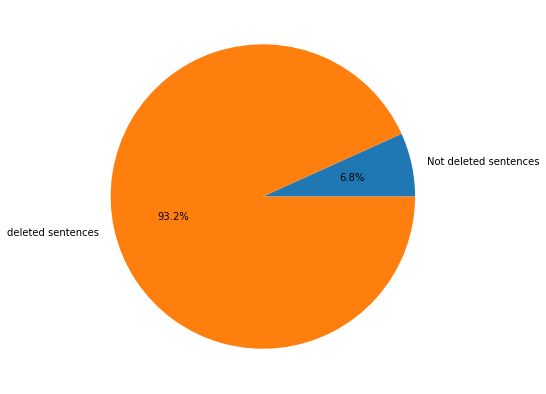

In [44]:
%%time
#For the concatentaed dataframe
calculate_percentage_deleted_sentences(df_dataset)

# of normal sentences in the dataframe  9618942
# of simplfied sentences in the dataframe  1228635
# of deleted sentences in the dataframe  8934143
Percentage of deleted sentences 92.88
CPU times: user 13.6 s, sys: 1.57 ms, total: 13.6 s
Wall time: 13.6 s


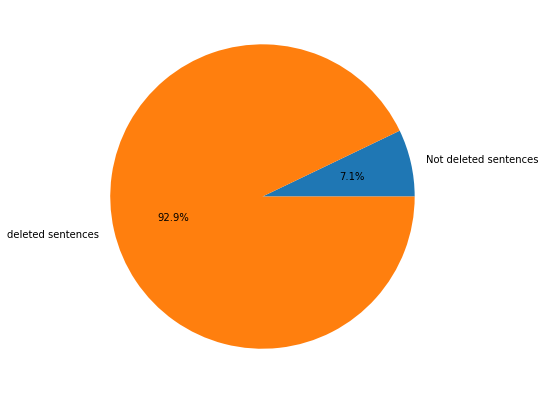

In [45]:
%%time
#For the first wiki_1 part
calculate_percentage_deleted_sentences(df_wiki_part_1)

# of normal sentences in the dataframe  525534
# of simplfied sentences in the dataframe  13036
# of deleted sentences in the dataframe  524564
Percentage of deleted sentences 99.82
CPU times: user 1.61 s, sys: 3.83 ms, total: 1.61 s
Wall time: 1.61 s


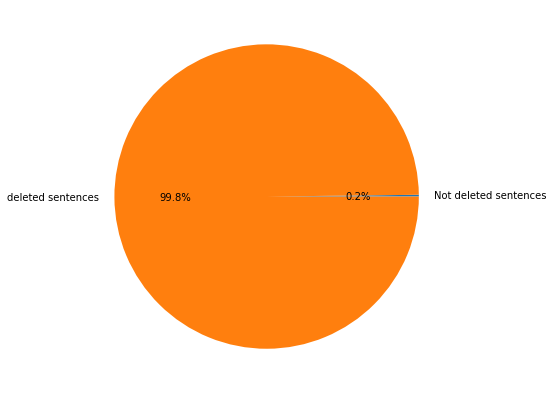

In [46]:
%%time
#For the first wiki_2 part
calculate_percentage_deleted_sentences(df_wiki_part_2)

In [ ]:
'''
leave it here for now!
This function is used to convert the structure of the json files to group the data by [simple, normal, sentence_alignment]
'''
def reformat_json_file(input_file, outpu_file):
    input_json_file = open(input_file,'r')
    input_data = json.load(input_json_file)
    input_json_file.close()
    data_list = []
    for key,value in input_data.items():
        data_list.append(value)

    output_json_file = open(outpu_file,"w")
    output_data = json.dumps(data_list)
    output_json_file.write(output_data)
    output_json_file.close()
    print("finished")